### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2024 Semester 2

## Assignment 3

**Student Name:**    `Riwaz Udas`

**Student ID:**     `1547555`

## This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

## Estimating depth from Stereo

Standard imports

In [1]:
import numpy as np
from numpy import inf
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import math


A function to load an image file from the Middlebury dataset and downsample it by a factor of scale

In [2]:
def loadim(filename, scale):
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = tf.cast(im,tf.float32)
    shape = im.shape
    shape = [1,*shape]
    im = tf.reshape(im,shape)
    im = tf.nn.avg_pool2d(input=im, ksize=(scale,scale), strides = (scale,scale), padding='VALID')
    return im

A function to load a disparity file from the Middlebury dataset and downsample it by a factor of scale

This function also modifies the offsets in the tensor by a factor of scale so that it is consistent with images at that scale

In [3]:
def loaddisparity(filename, scale):
    disp = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    with Path(filename).open('rb') as pfm_file:
        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
    fscale = abs(float(line3))

    # clean up the image and rescale
    disp[disp==inf]=0
    shape = disp.shape
    shape = [1,*shape,1]
    disp = tf.reshape(disp,shape)
    disp = tf.nn.max_pool2d(input = disp, ksize = (scale, scale), strides=(scale, scale), padding ='VALID')
    disp = disp * fscale / scale
    return disp


select a directory from the Middlebury dataset containing an image pair and corresponding disparities

The images are big (2016 high and 2940 wide) - so choose a scale to downsample them to more manageable size

Specify the size of window to use for matching

In [5]:
filepath = 'Middlebury/Backpack-perfect' # select a stereo pair to work on
scale = 8 # scale factor to shrink the images by
halfwin = 2 # number of pixels each side of the centre pixel to include in the matching window

Load two images and two disparities

In [6]:
im0 = loadim(filepath + '/im0.png', scale)
im1 = loadim(filepath + '/im1.png', scale)
disp0 = loaddisparity(filepath+'/disp0.pfm',scale)
disp1 = loaddisparity(filepath+'/disp1.pfm',scale)

Display them

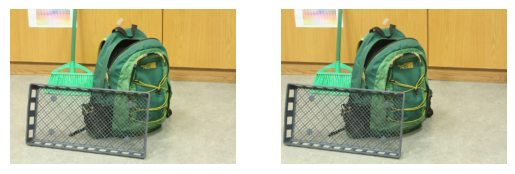

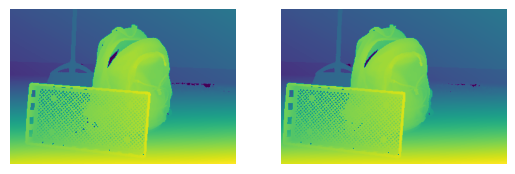

In [7]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(tf.cast(im0[0],tf.uint8).numpy())
axarr[0].set_axis_off()
axarr[1].imshow(tf.cast(im1[0],tf.uint8).numpy())
axarr[1].set_axis_off()

f, axarr = plt.subplots(1,2)
axarr[0].imshow(disp0[0])
axarr[0].set_axis_off()
axarr[1].imshow(disp1[0])
axarr[1].set_axis_off()

## Image warping

Use the ground truth disparity map to warp im0 to move the pixels to where they should be for im1

NB: this is very slow because we're workign one pixel at a time. At scale=8 this cell takes 15s on my M1 macbook air.

If you get worried that this is not working, try printing out i each time a row changes to monitor it

In [18]:
done = False
if scale>7:
    remapped = np.zeros(im0.shape)
    b,rows,cols,_ = im0.shape
    for i in range(rows):
        for j in range(cols):
            offset = disp0[0,i,j,0]
            joff = int(j-offset)
            if(offset > 0 and joff >=0 and joff < cols):
                remapped[0,i,joff,:] = im0[0,i,j,:]

Display the im0->im1 warped image alongside im1 for comparison

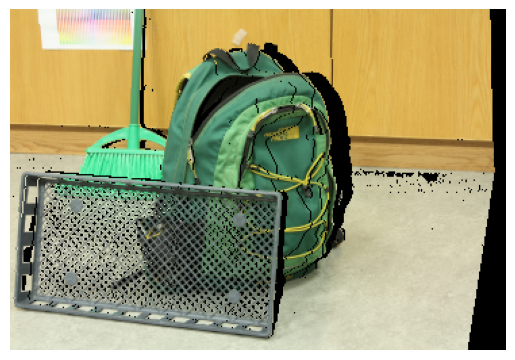

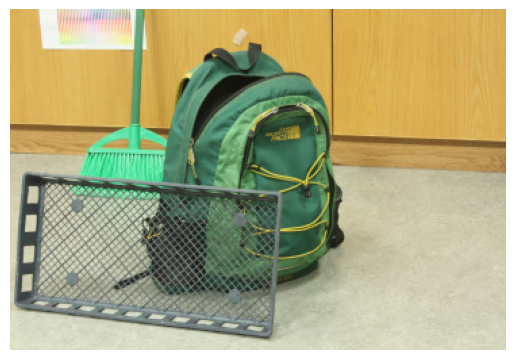

In [9]:
if scale > 7:
    plt.figure(0)
    fig=plt.imshow(tf.cast(remapped[0],tf.uint8).numpy())
    fig.axes.set_axis_off()
    plt.figure(1)
    fig=plt.imshow(tf.cast(im1[0],tf.uint8).numpy())
    fig.axes.set_axis_off()

## Compute Disparity

Conduct a sweep over offets computing the squared error at each pixel between im1 and a shifted im0

In [10]:
#cheat a bit so that we're only considering disparities up to the maximum disparity in the ground truth
maxoffset = math.ceil(float(tf.math.reduce_max(disp0)))

b,rows,cols,_ = im0.shape
diffsumsq = []

# scan over the offset range we're interested in
for offset in range(maxoffset):
    # shift im0 by offset and compute the difference to im1
    diff = im1[0,:,0:cols-maxoffset,:] - im0[0,:,offset:cols-maxoffset+offset,:]
    # square the errors
    diffsq = diff*diff
    # sum over r,g,b errors and stack the error images into a list
    diffsumsq.append(tf.math.reduce_sum(diffsq,axis=-1,keepdims=True))

# turn the list of error images into a tensor - batch dimension scans over the offsets
diffsumsq = tf.stack(diffsumsq)


Make a kernel to add up the squared errors within a window

In [20]:
windowsize = 2 * halfwin + 1

kshape = [windowsize,windowsize,1,1]
kernel = np.ones(kshape)

Convolve the kernel with the stack of squared error images to get the squared error within each window at each offset

In [12]:
windowdiffsumsq = tf.nn.conv2d(diffsumsq,kernel,strides=1,padding='VALID')

sample the offsets and display the sum squared error within each window at each offset

Features should disappear at the correct disparity

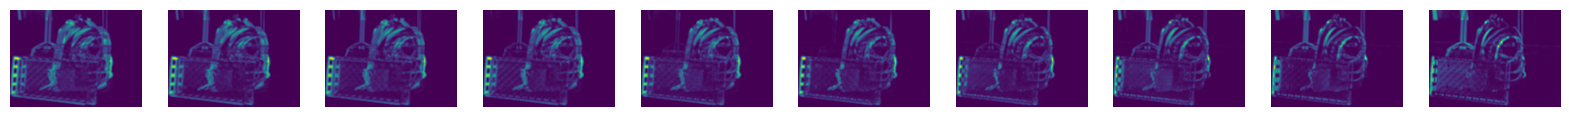

In [13]:
f, axarr = plt.subplots(1,10,figsize=(20,16))
for i in range(10):
    axarr[i].imshow(windowdiffsumsq[i*2])
    axarr[i].set_axis_off()

Find the best disparirty for each pixel by finding the position of the minimum error using argmin

In [14]:
bestoffset = tf.math.argmin(windowdiffsumsq, axis=0)
bestoffset = tf.cast(bestoffset,tf.float32)

Choose the part of the ground truth disparity image that corresponds to the one we have computed taking into account pixels lost due to windowing and from the disparity sweep

In [15]:
outr, outc, _ = bestoffset.shape
gt = disp1[0, halfwin:halfwin+outr, halfwin:halfwin+outc,:]

Display our computed disparity and the ground truth disparity

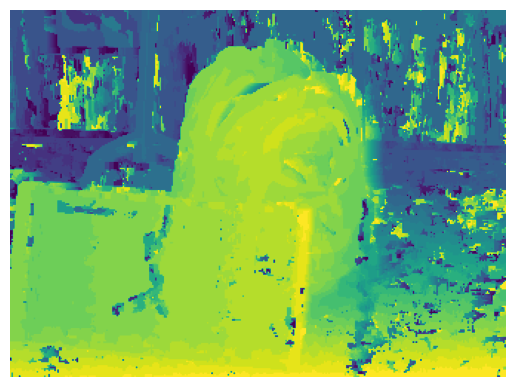

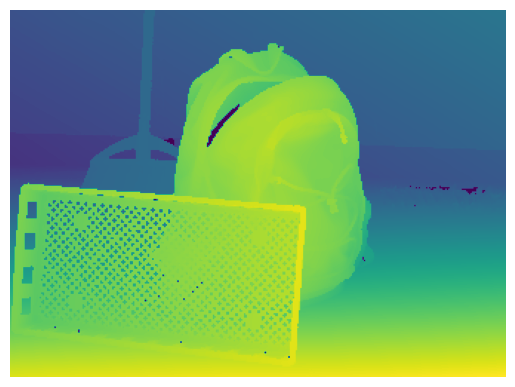

In [16]:
plt.figure(0)
fig = plt.imshow(bestoffset)
fig.axes.set_axis_off()
plt.figure(1)
fig = plt.imshow(gt)
fig.axes.set_axis_off()

Calculate how well we did.  Count the number of pixels for which we have a ground truth disparity that are within a disparity error of 2.5 pixels of the ground truth and report as an accuracy percentage

In [17]:
disperror = tf.math.abs(bestoffset - gt)

could = gt!=0
good = tf.logical_and(could, disperror < 2.5)

numgood = (int(tf.math.count_nonzero(good)))
numcould = (int(tf.math.count_nonzero(could)))

print (numgood, ' out of ', numcould, ' pixels = ', 100*numgood/numcould, '%')


64127  out of  82892  pixels =  77.36210973314674 %
